In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from datetime import datetime
sns.set_theme('notebook')
from functools import reduce

test the impact of the new trail layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores.

examining the performance in trial vs control stores to provide a recommendation for each location based on our insight.

Select control stores – explore the data and define metrics for the control store selection – think about what would make them a control store. Look at the drivers and make sure to visualise these in a graph to better determine if they are suited. For this piece it may even be worth creating a function to help. 

Assessment of the trial – this one should give you some interesting insights into each of the stores, check each trial store individually in comparison with the control store to get a clear view of its overall performance. We want to know if the trial stores were successful or not. 

Collate findings – summarise your findings for each store and provide an recommendation that we can share with Julia outlining the impact on sales during the trial period.



valuate the performance of a store trial which was performed in stores 77, 86 and 88.

consider the monthly sales experience of each store. 

- total sales revenue
- total number of customers
- average number of transactions per customer


Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.



Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

In [9]:
raw_data = pd.read_csv('data/QVI_data.csv')
df = raw_data.copy()

In [10]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


Select control stores

The client has selected store numbers 77, 86, 88 has trail stores and want control stores to be established store athat operational for the entire observation period

We would want to match trail stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of:
- Monthly overall sales revenue
- Monthly number of customers 
- Monthly number of transactions per customer

create the metrics of interest and filter to stores that are present throughout the pre-trail period period




In [11]:
# calculate these measures over time for each store
# add a new month ID column in the data with the format yyyym
df['YEARMONTH'] = [''.join(x.split('-')[0:2]) for x in df['DATE']]
df['YEARMONTH'] = pd.to_datetime(df['YEARMONTH'], format = '%Y%m')
df['DATE'] = pd.to_datetime(df['DATE'])


In [12]:
df.head(2)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10-01
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09-01


Next, define the measure calculations to use during the analysis. For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and average price per unit.

In [13]:
measureOverTime = df\
.groupby(['STORE_NBR', 'YEARMONTH'])\
.agg({'TOT_SALES': 'sum', 
     'LYLTY_CARD_NBR': 'nunique',
     'TXN_ID': 'nunique',
    'PROD_QTY': 'sum'
     })
measureOverTime.columns = ['totSales', 'nCustomers', 'nTxn', 'totChips']

measureOverTime['nTxnPerCust'] = measureOverTime['nTxn']/measureOverTime['nCustomers']
measureOverTime['nChipPerTxn'] = measureOverTime['totChips']/measureOverTime['nTxn']
measureOverTime['avgPricePerUnit'] = measureOverTime['totSales']/measureOverTime['totChips']

measureOverTime.drop(['nTxn', 'totChips'], axis = 1, inplace = True)

measureOverTime.head(2)

totSales  nCustomers  nTxnPerCust  nChipPerTxn  \
STORE_NBR YEARMONTH                                                    
1         2018-07-01     206.9          49     1.061224     1.192308   
          2018-08-01     176.1          42     1.023810     1.255814   

                      avgPricePerUnit  
STORE_NBR YEARMONTH                    
1         2018-07-01         3.337097  
          2018-08-01         3.261111

In [14]:
assert (measureOverTime.reset_index().groupby('STORE_NBR')['YEARMONTH'].agg('nunique') == 12).sum() == measureOverTime.reset_index().groupby('STORE_NBR').filter(lambda x: x['YEARMONTH'].nunique() == 12)['STORE_NBR'].nunique()


Filtering to the pre-trial period and stores with full observation periods 

filter out stores contains over one year data
and trail period of Fed 2019


In [15]:
storesWithFullObs = measureOverTime.reset_index().groupby('STORE_NBR').filter(lambda x: x['YEARMONTH'].nunique() == 12)

preTrialMeasures = storesWithFullObs.loc[storesWithFullObs['YEARMONTH'] < datetime(2019, 2, 1)]

Now we need to work out a way of ranking how simliar each potential control store is to the trail store. We can calculate how correlated the performance of each store is the trial store.

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance

Create a function to calculate a standardised magnitude distance for a measure.

In [36]:
def correlation_table_by_feature(target_store, feature, df=preTrialMeasures):
    corr = []
    nStore = df.STORE_NBR.nunique()
    a = df[df.STORE_NBR == target_store][feature]
    for i in df.STORE_NBR.unique():
        b = df[df.STORE_NBR == i][feature]
        cor_coe = np.corrcoef(a, b)[0, 1]
        corr.append(cor_coe)
    calcCorrTable =  pd.DataFrame({'target_store': [target_store]*nStore,
                           'compared_store': df.STORE_NBR.unique(),
                           'correlation': corr})
    return calcCorrTable


def magnitude_distance_by_feature(target_store, feature, df=preTrialMeasures):
    distance = []
    for i in df.STORE_NBR.unique():
        for j in df.YEARMONTH.unique():
            feature_otherstore_yearmonth = df[(df.STORE_NBR == i) & (df.YEARMONTH == j)][feature].values
            feature_targetstore_yearmonth = df[(df.STORE_NBR == target_store)&(df.YEARMONTH == j)][feature].values
            distance.append(np.round(abs(feature_otherstore_yearmonth - feature_targetstore_yearmonth), 3))
    distances_overtime_pair_stores = pd.DataFrame({'compared_store': df['STORE_NBR'].values,
                                                  'YEARMONTH': df['YEARMONTH'].values,
                                                  'DISTANCE': np.array(distance).flatten()})
    # standardise the magnitude distance so that the measure ranges from 0 to 1
    max_distance_yearmonth_allstores = distances_overtime_pair_stores.groupby('YEARMONTH')['DISTANCE'].max()
    min_distance_yearmonth_allstores = distances_overtime_pair_stores.groupby('YEARMONTH')['DISTANCE'].min()
    
    magnitude_distance = []
    for i in df.STORE_NBR.unique():
        feature_otherstore_overtime = df[df.STORE_NBR == i][feature].values
        feature_targetstore_overtime = df[df.STORE_NBR == target_store][feature].values
        nom = abs(feature_otherstore_overtime - feature_targetstore_overtime)
        measure = (1 - (nom - min_distance_yearmonth_allstores)/(max_distance_yearmonth_allstores - min_distance_yearmonth_allstores)).mean()
        magnitude_distance.append(measure)
    finalDistTable = pd.DataFrame({'target_store': [target_store]*df.STORE_NBR.nunique(),
                                  'compared_store': df.STORE_NBR.unique(),
                                  'magnitude_distance': magnitude_distance})
    
    return finalDistTable


Now use the functions to find the control stores. We'll select control stores based on how simliar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of sales and total customers.

## Store 77

In [37]:
correlation_table_by_feature(77, 'totSales')\
.sort_values('correlation', ascending = False)\
.head()

,target_store,compared_store,correlation
72,77,77,1.000000
67,77,71,0.914106
221,77,233,0.903774
111,77,119,0.867664
15,77,17,0.842668


In [38]:
correlation_table_by_feature(77, 'nCustomers')\
.sort_values('correlation', ascending = False)\
.head()

,target_store,compared_store,correlation
72,77,77,1.000000
221,77,233,0.990358
111,77,119,0.983267
241,77,254,0.916208
106,77,113,0.901348


In [39]:
magnitude_distance_by_feature(77, 'totSales')\
.sort_values('magnitude_distance', ascending = False)\
.head()

,target_store,compared_store,magnitude_distance
72,77,77,1.000000
221,77,233,0.985265
242,77,255,0.976721
49,77,53,0.975422
180,77,188,0.975177


In [40]:
magnitude_distance_by_feature(77, 'nCustomers')\
.sort_values('magnitude_distance', ascending = False)\
.head()

,target_store,compared_store,magnitude_distance
72,77,77,1.000000
221,77,233,0.992773
38,77,41,0.974639
104,77,111,0.966064
108,77,115,0.965916


Now need to combine the all the scores calculated using our function to create a composite score to rank on.<br>
Let's take a simple average of the correlation and magitude scores for each driver<br>
Note that if we consider it more important and magnitude scores for the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

Create a combined score composed of correlation and magnitude, by first merging the correlations table with the magnitude table.

A simple average on the scores would be 0.5 * correlation + 0.5 * magnitude distance


In [41]:
correlation_totSales = correlation_table_by_feature(77, 'totSales')
correlation_nCustomers = correlation_table_by_feature(77, 'nCustomers')
magDis_totSales = magnitude_distance_by_feature(77, 'totSales')
magDis_nCustomers = magnitude_distance_by_feature(77, 'nCustomers')



In [42]:
data_frames = [correlation_totSales, correlation_nCustomers, magDis_totSales, magDis_nCustomers]
df_merged = reduce(lambda left, right: pd.merge(left, right, on = ['target_store', 'compared_store'], how = 'left'), data_frames)

In [44]:
corr_weight = 0.5

df_merged['finalControlScore'] = corr_weight*(corr_weight*df_merged['correlation_x'] + (1 - corr_weight)*df_merged['magnitude_distance_x']) + (1-corr_weight)*(corr_weight*df_merged['correlation_y'] + (1 - corr_weight)*df_merged['magnitude_distance_y'])
                                  
                                  
df_merged.sort_values('finalControlScore', ascending = False).head(2)                           
                                  

,target_store,compared_store,correlation_x,correlation_y,magnitude_distance_x,magnitude_distance_y,finalControlScore
72,77,77,1.000000,1.000000,1.000000,1.000000,1.000000
221,77,233,0.903774,0.990358,0.985265,0.992773,0.968043


In [66]:
control_store = df_merged.sort_values('finalControlScore', ascending = False).iloc[1][1].astype(int)
target_store = 77
print('control store: ', control_store, 'target store: ', target_store)



control store:  233 target store:  77


Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial. We'll look at total sales first.


In [46]:
measureOverTimeSales = measureOverTime.reset_index()

conditions = [(measureOverTimeSales['STORE_NBR'] == target_store),
             (measureOverTimeSales['STORE_NBR'] == control_store),
             (~measureOverTimeSales['STORE_NBR'].isin([target_store, control_store]))]

values = ['Trial', 'Control', 'Other Stores']

measureOverTimeSales['store_type'] = np.select(conditions, values)

In [49]:
lineplot_ready_totSales = measureOverTimeSales.groupby(['YEARMONTH', 'store_type'])['totSales'].mean().reset_index()
lineplot_ready_totSales = lineplot_ready_totSales[lineplot_ready_totSales['YEARMONTH'] < '2019-03-01']

/Users/murongcui/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


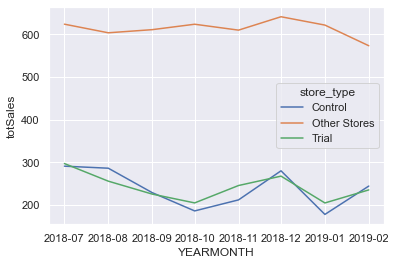

In [50]:
sns.lineplot(data = lineplot_ready_totSales, x = 'YEARMONTH', y = 'totSales', hue = 'store_type');


Next, number of customers

Conduct visual checks on customer count trends by comparing the trial store too the control store and other stores


In [51]:
lineplot_ready_nCustomers =  measureOverTimeSales.groupby(['YEARMONTH', 'store_type'])['nCustomers'].mean().reset_index()
lineplot_ready_nCustomers = lineplot_ready_nCustomers[lineplot_ready_nCustomers['YEARMONTH'] < '2019-03-01']



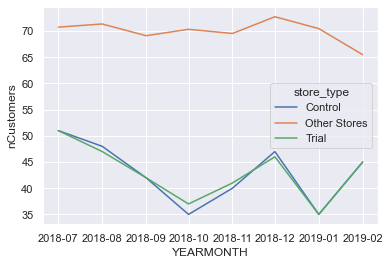

In [52]:
sns.lineplot(data = lineplot_ready_nCustomers, x = 'YEARMONTH', y = 'nCustomers', hue = 'store_type');

## Assessment of trial
The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

We'll start with scaling the control stores's sales to level simliar to control for any differences between the two stores outside of the trial period.






In [90]:
# scale pre-trial control sales to match pre-trial store sales
#scalingFactorForControlSales 
scalingFactorForControlsSales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == target_store]['totSales'].sum()/preTrialMeasures[preTrialMeasures['STORE_NBR'] == control_store]['totSales'].sum()

controlSales_control_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['totSales'].values*scalingFactorForControlsSales

totSales_target_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == target_store]['totSales'].values

time_series = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['YEARMONTH'].values


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period

Calculate the percentage difference between scaled control sales and trial sales


In [91]:
percentageDiff_sales = pd.DataFrame({'YEARMONTH': time_series,
             'totSales_target_store': totSales_target_store,
             'controlSales_control_store': controlSales_control_store,
             'percentageDiff': abs(controlSales_control_store - totSales_target_store)/controlSales_control_store})


percentageDiff_sales.head()





,YEARMONTH,totSales_target_store,controlSales_control_store,percentageDiff
0,2018-07-01,296.8,297.565550,0.002573
1,2018-08-01,255.5,292.652187,0.126950
2,2018-09-01,225.2,233.998916,0.037602
3,2018-10-01,204.5,190.085733,0.075830
4,2018-11-01,245.3,216.597421,0.132516


Let's see if difference is significant

As our null hypothesis is that trial period is the same as the pre-trial

Let's take the standard deviation based on the scaled percentage difference in pre-trial period

Note that there are 7 months in the pre-trial period<br>
hence 7-1 = 6 degrees of freedom<br>

We will test with a null hypothesis of there being 0 differnce between trial and control stores

Calculate the t-values for the trial months. After that, find the 95th percentage of the t distribution with the appropriate degrees of freedom

To check wheather the hypothesis is statistical significant

Construct t statistic test $\frac{x-\mu}{\text{standard deviation}}$

In [92]:

degreeOfFreedom = len(percentageDiff_sales[percentageDiff_sales['YEARMONTH'] < '2019-02-01']['percentageDiff']) - 1
stdDev = stats.tstd(percentageDiff_sales[percentageDiff_sales['YEARMONTH'] < '2019-02-01']['percentageDiff'].values)

degreeOfFreedom, stdDev

(6, 0.049940762641425544)

In [93]:
# percentageDiff_sales[(percentageDiff_sales['YEARMONTH'] > '2019-01-01') & (percentageDiff_sales['YEARMONTH'] < '2019-05-01')]['percentageDiff'].values/stdDev

t_test_table_sales = pd.DataFrame({'TransactionMonth': percentageDiff_sales[(percentageDiff_sales['YEARMONTH'] > '2019-01-01') & (percentageDiff_sales['YEARMONTH'] < '2019-05-01')]['YEARMONTH'],
                            'tValue': percentageDiff_sales[(percentageDiff_sales['YEARMONTH'] > '2019-01-01') & (percentageDiff_sales['YEARMONTH'] < '2019-05-01')]['percentageDiff'].values/stdDev})

t_test_table_sales



,TransactionMonth,tValue
7,2019-02-01,1.183534
8,2019-03-01,7.339116
9,2019-04-01,12.476373


Find the 95th percentile of the t distribution with the appropriate degrees of freedom to compare against

In [138]:
stats.t(df = degreeOfFreedom).ppf(0.975)

2.4469118487916806

We can observe that t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e the increase in sales in the trial store in March and April is statistically  greater than in the control store. Let's create a more visual version of the trial stores and 95th percentile value of sales of the control store.

In [124]:
def plot_ready_feature(target_store, control_store, feature, stdDev, df = measureOverTimeSales):
    pastSales = measureOverTimeSales[measureOverTimeSales['STORE_NBR'].isin([target_store, control_store])]
    Control95 = pastSales[pastSales['STORE_NBR'] == control_store][feature].values*(1+stdDev*2)
    Control5 =  pastSales[pastSales['STORE_NBR'] == control_store][feature].values*(1-stdDev*2)
    Trial = pastSales[pastSales['STORE_NBR'] == target_store][feature].values
    Control = pastSales[pastSales['STORE_NBR'] == control_store][feature].values
    
    all_feature = pd.DataFrame({'YEARMONTH': pastSales['YEARMONTH'].unique(),
             'Control95': Control95,
             'Control5': Control5,
             'Trial': Trial,
             'Control': Control})
    plot_ready_all_feature = pd.melt(all_feature, 
        id_vars = ['YEARMONTH'], 
        value_vars = ['Control95', 'Control5', 'Trial', 'Control'],
       var_name = 'store_type', 
       value_name = feature)
    return plot_ready_all_feature

def plot_overtime_between_control_trial(feature, df):
    plt.figure(figsize = (10, 10))
    ax = sns.lineplot(data = df, x = 'YEARMONTH', y = feature, hue = 'store_type');
    plt.ylim(0)
    ymin, ymax = plt.ylim()
    height = ymax - ymin
    interval = plt.xticks()[0][4] - plt.xticks()[0][3]
    ax.set_xticks(df['YEARMONTH'].unique())
    ax.add_patch(plt.Rectangle((plt.xticks()[0][8] - interval/2, ymin), 
                         interval, height, 
                         fill = True, 
                         alpha = 0.3))
    ax.lines[0].set_linestyle(':')
    ax.lines[1].set_linestyle(':')
    plt.xticks(rotation = 45)
    sns.despine();




In [125]:
plot_ready_all_totSales = plot_ready_feature(77, 233, 'totSales', stdDev)
plot_overtime_between_control_trial('totSales', plot_ready_all_totSales)

The results show that the trial in store 77 is significant different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months. Let's have a look at assessing this for number of customers as well.

Let's have a look at assessing this for number of customers as well.


In [94]:
# This would be a repeat of the steps before for total sales
# Scale pre-trial control customers to match pre-trial store customers
# Compute a scaling factor to align control store customer counts to our trial store
# Then, apply the scaling factor to control store customer counts
# Finally, calculate the percentage difference between scaled control store customers and trial customer

scalingFactorForControlsCust = preTrialMeasures[preTrialMeasures['STORE_NBR'] == target_store]['nCustomers'].sum()/preTrialMeasures[preTrialMeasures['STORE_NBR'] == control_store]['nCustomers'].sum()
nCust_control_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['nCustomers'].values*scalingFactorForControlsCust
nCust_target_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == target_store]['nCustomers'].values
time_series = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['YEARMONTH'].values



In [100]:
percentageDiff_nCust = pd.DataFrame({'YEARMONTH': time_series,
             'nCust_target_store': nCust_target_store,
             'controlnCust_control_store': nCust_control_store,
             'percentageDiff': abs(nCust_control_store - nCust_target_store)/nCust_control_store})


percentageDiff_nCust.head()

,YEARMONTH,nCust_target_store,controlnCust_control_store,percentageDiff
0,2018-07-01,51,51.171141,0.003344
1,2018-08-01,47,48.161074,0.024108
2,2018-09-01,42,42.140940,0.003344
3,2018-10-01,37,35.117450,0.053607
4,2018-11-01,41,40.134228,0.021572


In [102]:
degreeOfFreedom = len(percentageDiff_nCust[percentageDiff_nCust['YEARMONTH'] < '2019-02-01']['percentageDiff']) - 1
stdDev = stats.tstd(percentageDiff_nCust[percentageDiff_nCust['YEARMONTH'] < '2019-02-01']['percentageDiff'].values)

degreeOfFreedom, stdDev


(6, 0.01824074855824395)

In [103]:
t_test_table_nCust = pd.DataFrame({'TransactionMonth': percentageDiff_nCust[(percentageDiff_nCust['YEARMONTH'] > '2019-01-01') & (percentageDiff_nCust['YEARMONTH'] < '2019-05-01')]['YEARMONTH'],
                            'tValue': percentageDiff_nCust[(percentageDiff_nCust['YEARMONTH'] > '2019-01-01') & (percentageDiff_nCust['YEARMONTH'] < '2019-05-01')]['percentageDiff'].values/stdDev})

t_test_table_nCust

,TransactionMonth,tValue
7,2019-02-01,0.183352
8,2019-03-01,13.476388
9,2019-04-01,30.778725


In [139]:
stats.t(df = degreeOfFreedom).ppf(0.975)

2.4469118487916806

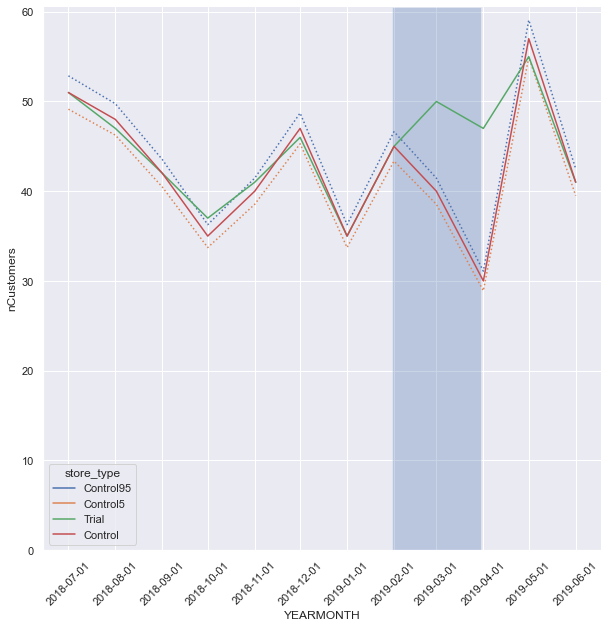

In [127]:
plot_ready_all_nCust = plot_ready_feature(77, 233, 'nCustomers', stdDev)
plot_overtime_between_control_trial('nCustomers', plot_ready_all_nCust)

## Store 86

Let's repeat finding the control and assessing the impact of the trial for each of the other two trial. stores # Trial Store 86

### Sales

In [107]:
correlation_totSales = correlation_table_by_feature(86, 'totSales')
correlation_nCustomers = correlation_table_by_feature(86, 'nCustomers')
magDis_totSales = magnitude_distance_by_feature(86, 'totSales')
magDis_nCustomers = magnitude_distance_by_feature(86, 'nCustomers')

In [108]:
data_frames = [correlation_totSales, correlation_nCustomers, magDis_totSales, magDis_nCustomers]
df_merged = reduce(lambda left, right: pd.merge(left, right, on = ['target_store', 'compared_store'], how = 'left'), data_frames)

In [109]:
corr_weight = 0.5
df_merged['finalControlScore'] = corr_weight*(corr_weight*df_merged['correlation_x'] + (1 - corr_weight)*df_merged['magnitude_distance_x']) + (1-corr_weight)*(corr_weight*df_merged['correlation_y'] + (1 - corr_weight)*df_merged['magnitude_distance_y'])
df_merged.sort_values('finalControlScore', ascending = False).head(2)            

,target_store,compared_store,correlation_x,correlation_y,magnitude_distance_x,magnitude_distance_y,finalControlScore
80,86,86,1.000000,1.000000,1.000000,1.000000,1.00000
147,86,155,0.877882,0.942876,0.962964,0.985037,0.94219


In [110]:
control_store = df_merged.sort_values('finalControlScore', ascending = False).iloc[1][1].astype(int)
target_store = 86
print('control store: ', control_store, 'target store: ', target_store)

control store:  155 target store:  86


In [111]:
measureOverTimeSales = measureOverTime.reset_index()
conditions = [(measureOverTimeSales['STORE_NBR'] == target_store),
             (measureOverTimeSales['STORE_NBR'] == control_store),
             (~measureOverTimeSales['STORE_NBR'].isin([target_store, control_store]))]
values = ['Trial', 'Control', 'Other Stores']
measureOverTimeSales['store_type'] = np.select(conditions, values)

In [120]:
lineplot_ready_totSales = measureOverTimeSales.groupby(['YEARMONTH', 'store_type'])['totSales'].mean().reset_index()
lineplot_ready_totSales = lineplot_ready_totSales[lineplot_ready_totSales['YEARMONTH'] < '2019-03-01']

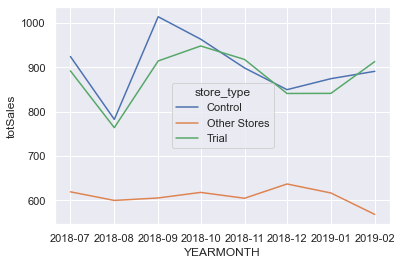

In [121]:
sns.lineplot(data = lineplot_ready_totSales, x = 'YEARMONTH', y = 'totSales', hue = 'store_type');

In [122]:
lineplot_ready_nCustomers =  measureOverTimeSales.groupby(['YEARMONTH', 'store_type'])['nCustomers'].mean().reset_index()
lineplot_ready_nCustomers = lineplot_ready_nCustomers[lineplot_ready_nCustomers['YEARMONTH'] < '2019-03-01']


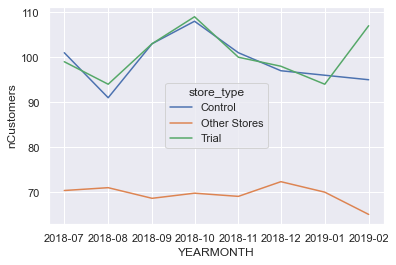

In [123]:
sns.lineplot(data = lineplot_ready_nCustomers, x = 'YEARMONTH', y = 'nCustomers', hue = 'store_type');

Looks like store 155 will be a control store for trial store 86. Again, let's check visually if the drivers are indeed similar in the period before the trial.Sales are trending in a similar way. The trend in number of customers is also similar. 

Let's now assess the impact of the trial on sales


In [128]:
# scale pre-trial control sales to match pre-trial store sales
#scalingFactorForControlSales 
scalingFactorForControlsSales = preTrialMeasures[preTrialMeasures['STORE_NBR'] == target_store]['totSales'].sum()/preTrialMeasures[preTrialMeasures['STORE_NBR'] == control_store]['totSales'].sum()
controlSales_control_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['totSales'].values*scalingFactorForControlsSales
totSales_target_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == target_store]['totSales'].values
time_series = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['YEARMONTH'].values


In [129]:
percentageDiff_sales = pd.DataFrame({'YEARMONTH': time_series,
             'totSales_target_store': totSales_target_store,
             'controlSales_control_store': controlSales_control_store,
             'percentageDiff': abs(controlSales_control_store - totSales_target_store)/controlSales_control_store})
percentageDiff_sales.head()


,YEARMONTH,totSales_target_store,controlSales_control_store,percentageDiff
0,2018-07-01,892.20,896.922236,0.005265
1,2018-08-01,764.05,759.269991,0.006296
2,2018-09-01,914.60,984.034086,0.070561
3,2018-10-01,948.40,934.948790,0.014387
4,2018-11-01,918.00,871.894555,0.052880


In [130]:
degreeOfFreedom = len(percentageDiff_sales[percentageDiff_sales['YEARMONTH'] < '2019-02-01']['percentageDiff']) - 1
stdDev = stats.tstd(percentageDiff_sales[percentageDiff_sales['YEARMONTH'] < '2019-02-01']['percentageDiff'].values)

degreeOfFreedom, stdDev

(6, 0.025833952854772586)

In [131]:
t_test_table_sales = pd.DataFrame({'TransactionMonth': percentageDiff_sales[(percentageDiff_sales['YEARMONTH'] > '2019-01-01') & (percentageDiff_sales['YEARMONTH'] < '2019-05-01')]['YEARMONTH'],
                            'tValue': percentageDiff_sales[(percentageDiff_sales['YEARMONTH'] > '2019-01-01') & (percentageDiff_sales['YEARMONTH'] < '2019-05-01')]['percentageDiff'].values/stdDev})
t_test_table_sales

,TransactionMonth,tValue
7,2019-02-01,2.179542
8,2019-03-01,12.226922
9,2019-04-01,1.364580


In [140]:
stats.t(df = degreeOfFreedom).ppf(0.975)

2.4469118487916806

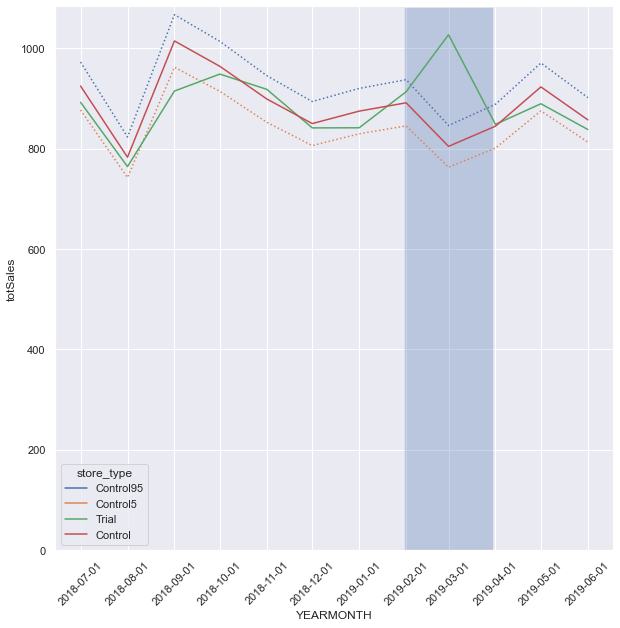

In [133]:
plot_ready_all_totSales = plot_ready_feature(86, 155, 'totSales', stdDev)
plot_overtime_between_control_trial('totSales', plot_ready_all_totSales)

### Number of Customers

In [145]:
scalingFactorForControlsCust = preTrialMeasures[preTrialMeasures['STORE_NBR'] == target_store]['nCustomers'].sum()/preTrialMeasures[preTrialMeasures['STORE_NBR'] == control_store]['nCustomers'].sum()
nCust_control_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['nCustomers'].values*scalingFactorForControlsCust
nCust_target_store = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == target_store]['nCustomers'].values
time_series = measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store]['YEARMONTH'].values


In [146]:
percentageDiff_nCust = pd.DataFrame({'YEARMONTH': time_series,
             'nCust_target_store': nCust_target_store,
             'controlnCust_control_store': nCust_control_store,
             'percentageDiff': abs(nCust_control_store - nCust_target_store)/nCust_control_store})


percentageDiff_nCust.head()

,YEARMONTH,nCust_target_store,controlnCust_control_store,percentageDiff
0,2018-07-01,99,101.0,0.019802
1,2018-08-01,94,91.0,0.032967
2,2018-09-01,103,103.0,0.000000
3,2018-10-01,109,108.0,0.009259
4,2018-11-01,100,101.0,0.009901


In [147]:
target_store, control_store

(86, 155)

In [148]:
degreeOfFreedom = len(percentageDiff_nCust[percentageDiff_nCust['YEARMONTH'] < '2019-02-01']['percentageDiff']) - 1
stdDev = stats.tstd(percentageDiff_nCust[percentageDiff_nCust['YEARMONTH'] < '2019-02-01']['percentageDiff'].values)

degreeOfFreedom, stdDev

(6, 0.010687444701395238)

In [149]:
t_test_table_nCust = pd.DataFrame({'TransactionMonth': percentageDiff_nCust[(percentageDiff_nCust['YEARMONTH'] > '2019-01-01') & (percentageDiff_nCust['YEARMONTH'] < '2019-05-01')]['YEARMONTH'],
                            'tValue': percentageDiff_nCust[(percentageDiff_nCust['YEARMONTH'] > '2019-01-01') & (percentageDiff_nCust['YEARMONTH'] < '2019-05-01')]['percentageDiff'].values/stdDev})

t_test_table_nCust

,TransactionMonth,tValue
7,2019-02-01,11.819082
8,2019-03-01,20.903430
9,2019-04-01,5.670772


In [150]:
stats.t(df = degreeOfFreedom).ppf(0.975)

2.4469118487916806

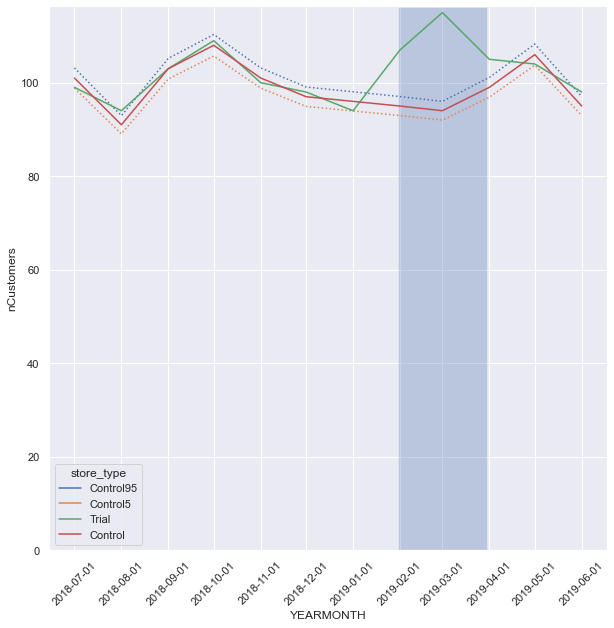

In [151]:
plot_ready_all_nCust = plot_ready_feature(86, 155, 'nCustomers', stdDev)
plot_overtime_between_control_trial('nCustomers', plot_ready_all_nCust)

## Store 88